
# Ehlers Cybernetic analysis for stocks and futures
## Hilber Transform

In [20]:
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 14, 7

In [21]:
# Import some useful libraries and tools
import pandas as pd
import numpy as np
from scipy import signal
from numpy import pi

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

In [22]:
def signal_generator(x, amplitude = 1, wavelenght=30, phase=0, origin=0):
    return amplitude * np.sin(2 * pi * x /wavelenght + phase * pi / 180) + origin

In [23]:
t = np.array(range(400))
a = signal_generator(t[:100], wavelenght=40)
b = signal_generator(t[100:200], wavelenght=100)
c = signal_generator(t[200:300], wavelenght=20)
d = signal_generator(t[300:], wavelenght=60)
x = np.concatenate((a, b, c, d))

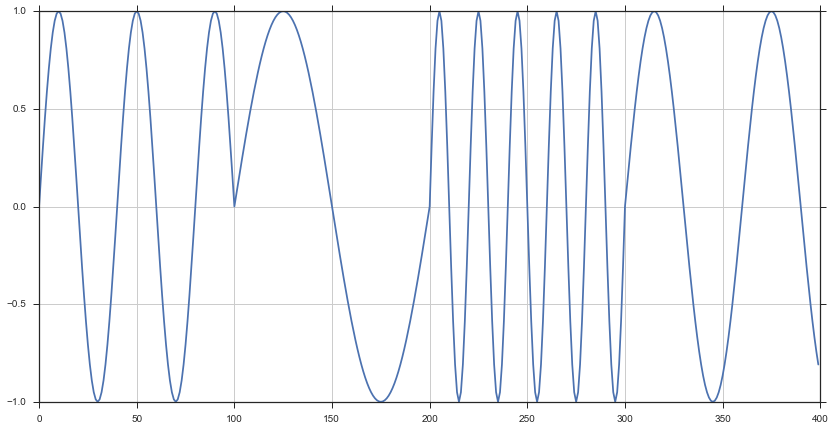

In [24]:
plt.plot(t, x)
plt.grid()

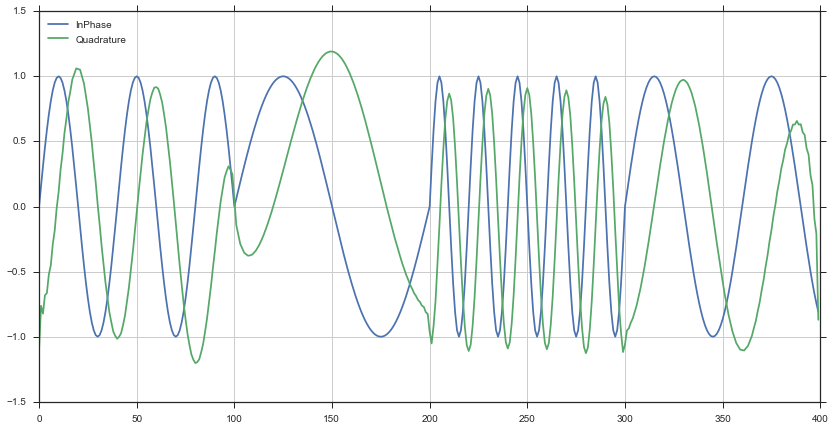

In [25]:
# Use the scipy hilbert tranform to estimate the analitic signal.
h = signal.hilbert(x)
plt.plot(t, np.real(h), label='InPhase')
plt.plot(t, np.imag(h), label='Quadrature')
plt.legend(loc='upper left')
plt.grid()

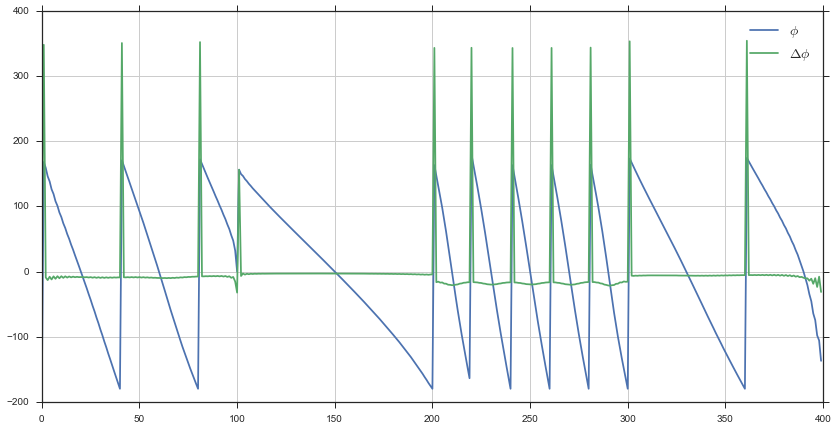

In [26]:
# Estimate the phase and the phase first difference.
phi = np.arctan2(np.real(h), np.imag(h)) * 180.0 / pi
delta_phi = np.append([0], np.diff(phi))
plt.plot(t, phi, label='$\phi$')
plt.plot(t, delta_phi, label='$\Delta\phi$')
plt.grid()

plt.legend(loc='upper right', fontsize=14)

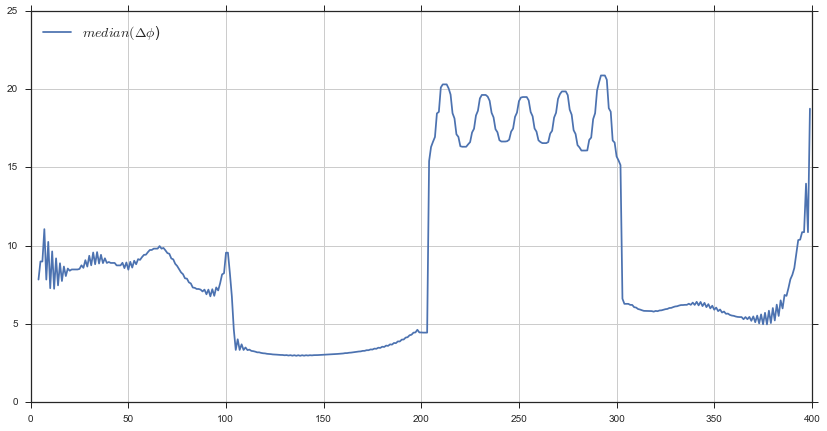

In [27]:
# Apply a median rolling window 
median_delta = np.abs(pd.rolling_median(delta_phi, 5))

plt.plot(t, median_delta, label='$median(\Delta\phi$)')
plt.grid()
plt.legend(loc='upper left', fontsize=14)

In [28]:
# Transform the delta phase to degrees.
dc = 360 / median_delta
# Estimate the period as Ehlers indicates.
inst_period = np.zeros(len(dc))
period = np.zeros(len(dc))
for i in range(4, len(dc)):
    inst_period[i] = 0.33 * dc[i] + 0.67 * inst_period[i-1]
    period[i] = 0.15 * inst_period[i] + 0.85 * period[i-1]

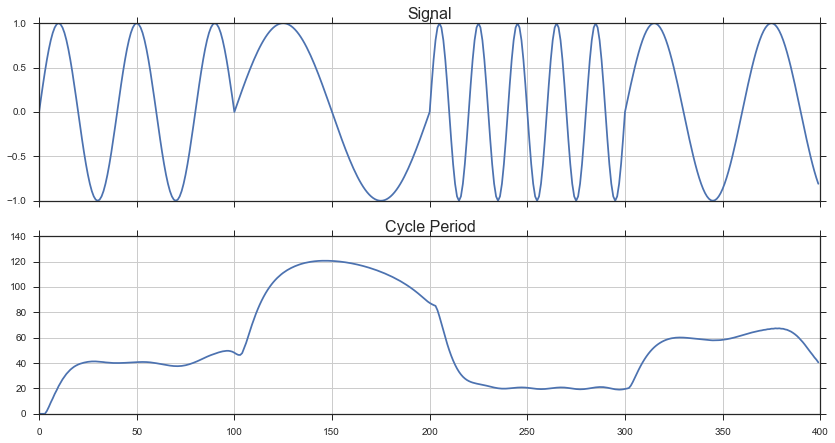

In [29]:
fig, ax = plt.subplots(2, sharex=True)
ax[0].set_title('Signal', fontsize=16)
ax[0].plot(t, x)
ax[0].grid()
ax[1].set_title('Cycle Period', fontsize=16)
ax[1].plot(t, period)
ax[1].grid()

The periods are estimated with some accuracy.
However, takes approximately 20 bars to converge!

In [30]:
# Putting everything together in a function
def cycle_period(t, x, plotting=True):
    h = signal.hilbert(x)
    phi = np.arctan2(np.real(h), np.imag(h)) * 180.0 / pi
    delta_phi = np.append([0], np.diff(phi))
    median_delta = np.abs(pd.rolling_median(delta_phi, 5))
    dc = np.zeros(len(x))
    inst_period = np.zeros(len(x))
    period = np.zeros(len(x))
    for i in range(4, len(x)):
        dc[i] = 360 / median_delta[i] + 0.5 if median_delta[i] != 0 else 15
        inst_period[i] = 0.33 * dc[i] + 0.67 * inst_period[i-1]
        period[i] = 0.15 * inst_period[i] + 0.85 * period[i-1]

    if plotting:
        fig, ax = plt.subplots(2, sharex=True)
        ax[0].set_title('Signal', fontsize=16)
        ax[0].plot(t, x)
        ax[0].grid()
        ax[1].set_title('Cycle Period', fontsize=16)
        ax[1].plot(t, period)
        ax[1].grid()
    
    return period

Now I'll try the same estimation, following strictly the formulas from the book (page 111), even the delta_phase estimation.
I need to make the calculation in a for because the quadrature has a lagged inst_period component.

In [31]:
quad_a = 0.0962
quad_b = 0.5769
quadrature = np.zeros(len(t))
in_phase = np.zeros(len(t))
phi = np.zeros(len(t))
delta_phi = np.zeros(len(t))
median_delta = np.zeros(len(t))
dc = np.zeros(len(t))
inst_period = np.zeros(len(t))
period = np.zeros(len(t))

for i in range(6, len(dc)):
    quadrature[i] = (quad_a * x[i] + quad_b * x[i-2] - quad_b * x[i-4] - quad_a * x[i-6]) * \
                    (0.5 + 0.08 * inst_period[i-1])
    in_phase[i] = x[i-3]
    #phi[i] = np.arctan2(in_phase[i], quadrature[i]) * 180.0 / pi
    #delta_phi[i] = phi[i] - phi[i-1]
    delta_phi[i] = (in_phase[i] / quadrature[i] - in_phase[i-1] / quadrature[i-1]) / \
                   (1 + in_phase[i] * in_phase[i-1] / (quadrature[i] * quadrature[i-1]))
    median_delta[i] = np.median(delta_phi[i-5:i])
    dc[i] = 360 / median_delta[i] + 0.5 if median_delta[i] != 0 else 15
    inst_period[i] = 0.33 * dc[i] + 0.67 * inst_period[i-1]
    period[i] = 0.15 * inst_period[i] + 0.85 * period[i-1]

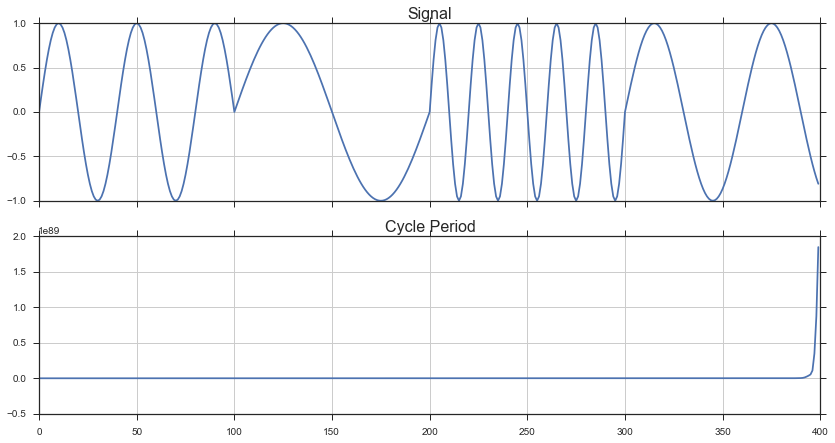

In [32]:
fig, ax = plt.subplots(2, sharex=True)
ax[0].set_title('Signal', fontsize=16)
ax[0].plot(t, x)
ax[0].grid()
ax[1].set_title('Cycle Period', fontsize=16)
ax[1].plot(t, period)
ax[1].grid()

Definitely there are something wrong with Elhers formulas.
Anyway, let's try the cycle_period function in real data.

In [33]:
# Now load some data, specifically AAPL minute data from 2015-07-14
df = pd.read_csv('https://drive.google.com/uc?export=download&id=0B9-kA56h5JCMbXptY0kyVXZXaUU',
                 index_col=0, parse_dates=True)
prices = df.CLOSE.as_matrix()

In [34]:
# First, estimate the detrended serie.
alpha = 0.07
a_ = (1 - alpha / 2) ** 2
b_ = (1 - alpha)

smooth = np.zeros(len(prices))
cycle = np.zeros(len(prices))

for i in range(3, len(prices)):
    smooth[i] = (prices[i] + 2 * prices[i-1] + 2 * prices[i-2] + prices[i-3]) / 6
    if i < 5:
        cycle[i] = (prices[i] - 2 * prices[i-1] + prices[i-2]) / 4
    else:
        cycle[i] = a_ * (smooth[i] - 2 * smooth[i-1] + smooth[i-2]) + \
                   2 * b_ * cycle[i-1] - (b_ ** 2) * cycle[i-2]

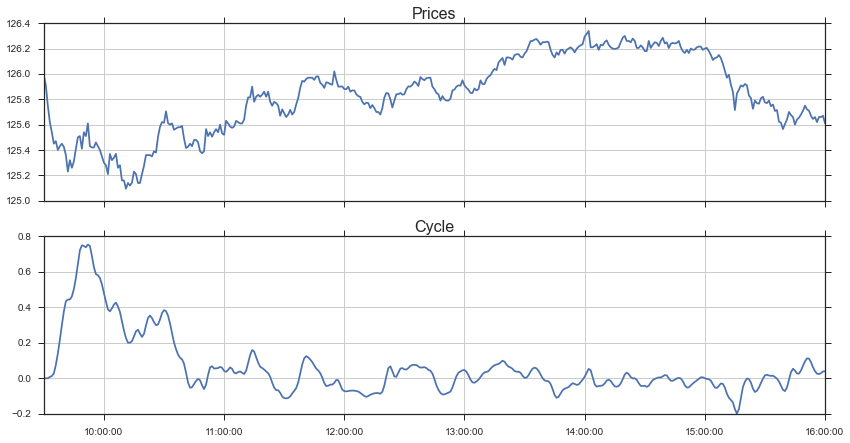

In [35]:
t = df.index
fig, ax = plt.subplots(2, sharex=True)
ax[0].set_title('Prices', fontsize=16)
ax[0].plot(t, prices, label='prices')
ax[0].grid()
ax[1].set_title('Cycle', fontsize=16)
ax[1].plot(t, cycle)
ax[1].grid()

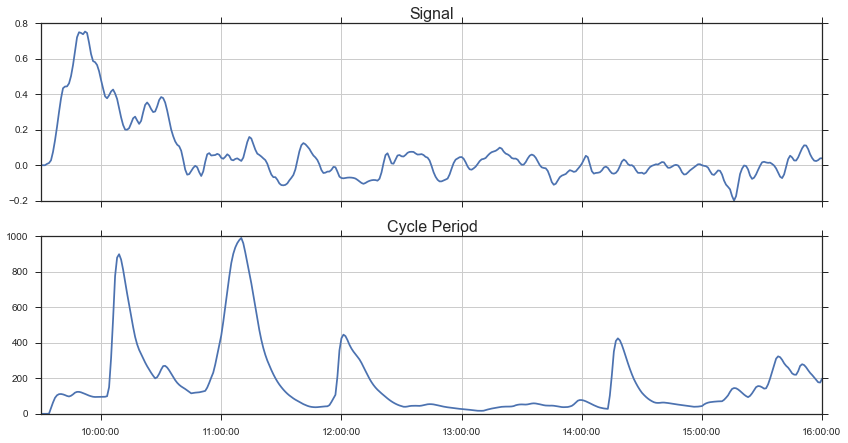

In [36]:
period = cycle_period(t, cycle)

Elhers uses a hard limit to the cycle period, here is clear why. 

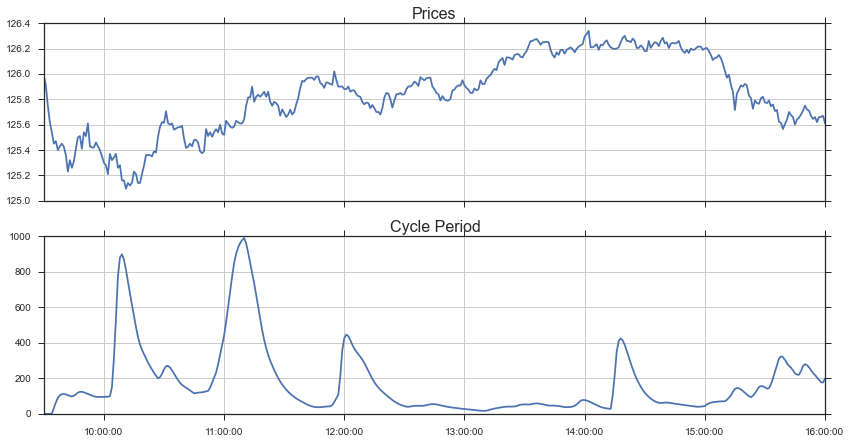

In [37]:
fig, ax = plt.subplots(2, sharex=True)
ax[0].set_title('Prices', fontsize=16)
ax[0].plot(t, prices, label='prices')
ax[0].grid()
ax[1].set_title('Cycle Period', fontsize=16)
ax[1].plot(t, period)
ax[1].grid()